# Notebook for code development for vehicle stock module (vsm)

- 21 Oct 2025 - don't trust the vehicle stock data from starter kit or ministry. basing everything off PKM --> better utility as it can be used without houndin' the data
- 26 Oct 2025 - removed reliance on Kenya age data - don't trust it. Calibrating a "steady state" age distribution based on Zambian data for annual additions/new vehicles

In [168]:

# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# INPUT DATA

In [169]:
def return_input_data():
    """
    Returns input data for vehicle stock model.

    PKM data based on CCG Transport Starter Data Kit for Zambia plus estimates:
    - Road motorized: 17,857.36 million pkm (2018) - CAR 50%, BUS 37.5%, MOTO 12.5%
    - Rail: 40 million pkm (estimated from passenger counts)
    - Aviation: 67.97 million pkm (UN DESA 2018)
    - Walk: 17,000 million pkm (estimated: 2.6 km/day per person average)
    - Bike: 3,000 million pkm (estimated: 0.5 km/day per person average)

    Total passenger transport: ~37,965 million pkm (2018)
    Note: NMT represents 53% of total passenger PKM, reflecting Zambia's mobility reality
    """

    # Base year 2018 values
    base_total_road_pkm = 17857.36
    car_share = 0.50
    bus_share = 0.375
    moto_share = 0.125

    base_car = base_total_road_pkm * car_share      # 8,928.68
    base_bus = base_total_road_pkm * bus_share      # 6,696.51
    base_moto = base_total_road_pkm * moto_share    # 2,232.17
    base_train = 40.0     # Estimated from passenger counts (~390k passengers × 100km)
    base_plane = 67.97    # UN DESA
    base_walk = 17000.0   # Urban: 4,730M + Rural: 12,446M pkm (2.6 km/day avg)
    base_bike = 3000.0    # ~5% of trips, 5km avg distance (0.5 km/day avg)

    # Annual growth rates
    road_growth_rate = 1.029   # 2.9% annual
    rail_growth_rate = 1.015   # 1.5% annual (infrastructure constrained)
    aviation_growth_rate = 1.04  # 4% annual (faster growing)
    nmt_growth_rate = 1.005    # 0.5% annual (NMT slowly declining as motorization increases)

    # === PASSENGER TRANSPORT (passenger-kilometres, million pkm) ===
    pkm_by_mode = {}

    for i, year in enumerate(range(2018, 2031)):
        road_growth = road_growth_rate ** i
        rail_growth = rail_growth_rate ** i
        avia_growth = aviation_growth_rate ** i
        nmt_growth = nmt_growth_rate ** i

        # Pandemic dip in 2020
        if year == 2020:
            road_growth *= 0.98
            rail_growth *= 0.90
            avia_growth *= 0.50
            nmt_growth *= 1.03  # NMT increased during pandemic as people avoided crowded transport

        pkm_by_mode[year] = {
            'CAR': round(base_car * road_growth, 1),
            'BUS': round(base_bus * road_growth, 1),
            'MOTO': round(base_moto * road_growth, 1),
            'TRAIN': round(base_train * rail_growth, 1),
            'PLANE': round(base_plane * avia_growth, 1),
            'WALK': round(base_walk * nmt_growth, 1),
            'BIKE': round(base_bike * nmt_growth, 1)
        }

    # === FREIGHT TRANSPORT (tonne-kilometres, million tkm) ===
    base_road_freight = 5234.54
    base_rail_freight = 297
    base_air_freight = 81.56
    base_waterway_freight = 13.32

    tkm_by_mode = {}
    freight_growth = 1.025  # 2.5% annual growth

    for i, year in enumerate(range(2018, 2031)):
        growth = freight_growth ** i

        tkm_by_mode[year] = {
            'TRUCK': round(base_road_freight * growth, 1),
            'RAIL_FREIGHT': round(base_rail_freight * growth, 1),
            'AIR_FREIGHT': round(base_air_freight * growth, 1),
            'SHIP': round(base_waterway_freight * growth, 1)
        }

    # === OCCUPANCY / LOAD FACTORS ===
    occ_by_mode = {
        year: {
            'BUS': 15,
            'CAR': 2.5,
            'MOTO': 1.5,
            'TRAIN': 200,
            'PLANE': 150,
            'WALK': 1,      # Self-propelled, 1 person
            'BIKE': 1,      # Self-propelled, 1 person
            'TRUCK': 10,
            'RAIL_FREIGHT': 1000,
            'SHIP': 20000,
            'AIR_FREIGHT': 50
        }
        for year in range(2018, 2031)
    }

    # === AVERAGE ANNUAL KILOMETRAGE ===
    kilometrage_by_mode = {
        year: {
            'BUS': 30000,
            'CAR': 15000,
            'MOTO': 12000,
            'TRAIN': 150000,
            'PLANE': 2000000,
            'WALK': 950,       # 2.6 km/day × 365 days
            'BIKE': 1825,      # 5 km/day × 365 days
            'TRUCK': 100000,
            'RAIL_FREIGHT': 100000,
            'SHIP': 600000,
            'AIR_FREIGHT': 2000000
        }
        for year in range(2018, 2031)
    }

    return pkm_by_mode, tkm_by_mode, occ_by_mode, kilometrage_by_mode

In [170]:
# return age data - NEW STOCK (based on Zambian vehicle registration data (Malindi))
def return_age_data_new_stock():
    new_age_data = pd.read_csv('./../data/vehicle_stock/age_distribution_new_vehicles.csv')
    return new_age_data

In [171]:
# return age data - CUMULATIVE STOCK (based on calibrated long-run of Zambian vehicle registration data)
def return_age_data_cumulative_stock():
    age_data = pd.read_csv('./../data/vehicle_stock/base_year_age_distribution.csv')
    return age_data

In [172]:
# Scrappage curves
def generate_scrappage_curves(max_age=30):
    """
    Generate scrappage rates (age-specific) for various modes
    Returns DataFrame indexed by age, columns = modes, where values are
    scrappage rate from age → age+1.
    """
    # Kenya-calibrated parameters (Weibull survival)
    params = {
        'CAR':     {'eta': 14, 'beta': 3.0},
        'MOTO':    {'eta': 9,  'beta': 2.5},
        'BUS':     {'eta': 12, 'beta': 3.5},
        'TRUCK':   {'eta': 10, 'beta': 3.2},
        'TRAIN':   {'eta': 25, 'beta': 3.5},
        'PLANE':   {'eta': 25, 'beta': 3.0},
        'SHIP':    {'eta': 30, 'beta': 3.5}
    }

    ages = np.arange(0, max_age + 1)
    scrappage = pd.DataFrame(index=ages, columns=params.keys(), dtype=float)

    for mode, p in params.items():
        S = np.exp(- (ages / p['eta']) ** p['beta'])
        # Scrappage rate: proportion that exit between a and a+1
        # i.e. 1 - S(a+1)/S(a)
        # For final age, assume full scrappage
        rates = 1 - (S[1:] / S[:-1])
        # Append rate = 1 for last age (everything scrapped)
        rates = np.append(rates, 1.0)
        scrappage[mode] = rates

    return scrappage

# BASE YEAR STOCK

In [173]:
def calculate_base_year_stock(base_year=2018):
    """
    Calculate the actual number of vehicles by mode and age in the base year.

    Uses:
    - PKM data for base year
    - Occupancy rates
    - Kilometrage (annual km per vehicle)
    - Base year age distribution (proportions)

    Returns:
    Dictionary of form {year: {mode: {age: vehicle_count}}}
    """
    # Get input data
    pkm_by_mode, tkm_by_mode, occ_by_mode, kilometrage_by_mode = return_input_data()

    # Get base year age distribution (proportions)
    age_distribution = return_age_data_cumulative_stock()

    # Initialize output dictionary
    base_year_stock = {base_year: {}}

    # Modes we're modelling
    modes = ['CAR', 'BUS', 'MOTO']

    for mode in modes:
        # Skip if mode not in age distribution
        if mode not in age_distribution.columns:
            continue

        # Calculate total number of vehicles needed for this mode
        # vehicles = PKM / (occupancy * annual_km_per_vehicle)
        pkm = pkm_by_mode[base_year][mode]  # million pkm
        occupancy = occ_by_mode[base_year][mode]  # passengers per vehicle
        annual_km = kilometrage_by_mode[base_year][mode]  # km per vehicle per year

        # Total vehicles needed
        total_vehicles = (pkm * 1e6) / (occupancy * annual_km)

        # Get age distribution for this mode (proportions)
        age_props = age_distribution[mode].values

        # Distribute total vehicles across ages according to proportions
        vehicles_by_age = {}
        for age in range(len(age_props)):
            vehicles_by_age[age] = total_vehicles * age_props[age]

        # Store in output dictionary
        base_year_stock[base_year][mode] = vehicles_by_age

    return base_year_stock

In [174]:
base_year_stock = calculate_base_year_stock()

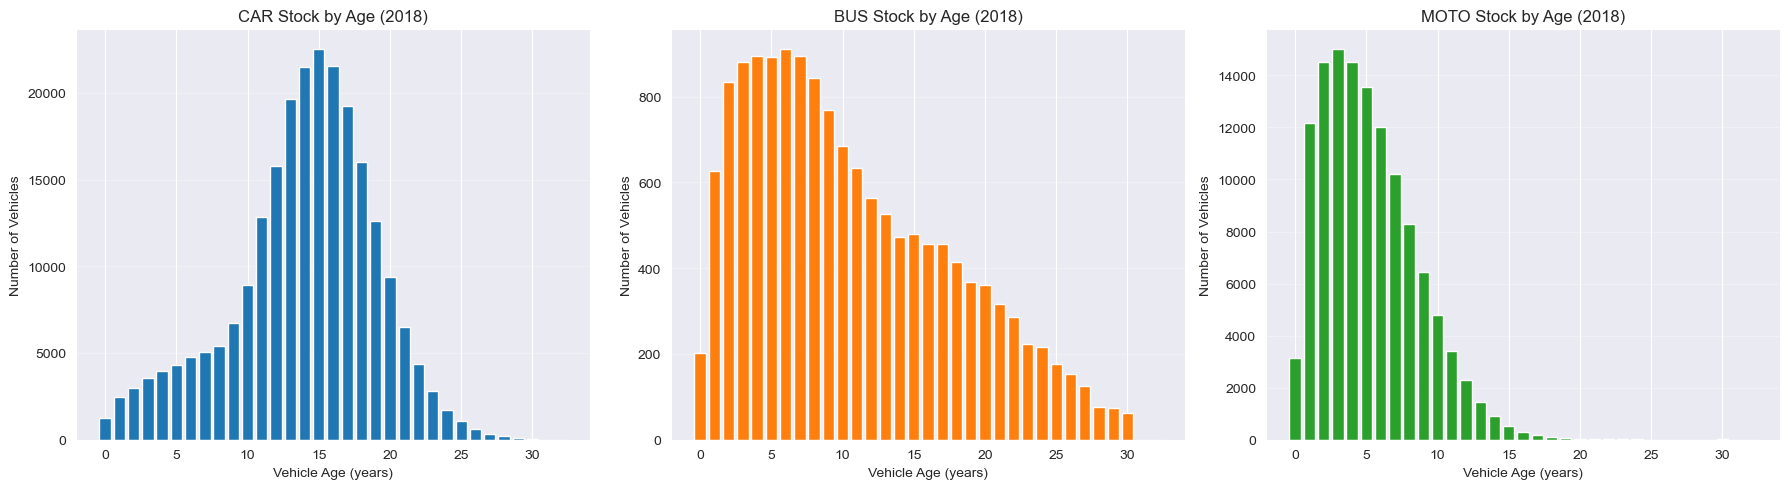

In [175]:
# Validation plot

validation_plot=1

if validation_plot>0:
    # Calculate base year stock
    base_year_stock = calculate_base_year_stock(base_year=2018)

    # Extract data for plotting
    modes = ['CAR', 'BUS', 'MOTO']
    ages = list(range(33))  # 0 to 32

    # Set up the plot
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for idx, mode in enumerate(modes):
        ax = axes[idx]

        # Get vehicle counts by age for this mode
        vehicle_counts = [base_year_stock[2018][mode].get(age, 0) for age in ages]

        # Create bar chart
        ax.bar(ages, vehicle_counts, color=sns.color_palette()[idx])
        ax.set_xlabel('Vehicle Age (years)')
        ax.set_ylabel('Number of Vehicles')
        ax.set_title(f'{mode} Stock by Age (2018)')
        ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

# DESIRED STOCK BY YEAR

In [176]:
def calculate_desired_stock(start_year=2018, end_year=2030, modes=['CAR', 'BUS', 'MOTO']):
    """
    Calculate the desired total vehicle stock by mode and year.

    Uses:
    - PKM data for each year
    - Occupancy rates
    - Kilometrage (annual km per vehicle)

    Returns:
    Dictionary of form {year: {mode: total_vehicles}}
    """
    # Get input data
    pkm_by_mode, tkm_by_mode, occ_by_mode, kilometrage_by_mode = return_input_data()

    # Initialize output dictionary
    desired_stock = {}

    for year in range(start_year, end_year + 1):
        desired_stock[year] = {}

        for mode in modes:
            # Calculate total number of vehicles needed for this mode
            # vehicles = PKM / (occupancy * annual_km_per_vehicle)
            pkm = pkm_by_mode[year][mode]  # million pkm
            occupancy = occ_by_mode[year][mode]  # passengers per vehicle
            annual_km = kilometrage_by_mode[year][mode]  # km per vehicle per year

            # Total vehicles needed
            total_vehicles = (pkm * 1e6) / (occupancy * annual_km)

            desired_stock[year][mode] = total_vehicles

    return desired_stock

In [177]:
# Validation check
desired = calculate_desired_stock()
base = calculate_base_year_stock()

for mode in ['CAR', 'BUS', 'MOTO']:
    desired_total = desired[2018][mode]
    base_total = sum(base[2018][mode].values())
    print(f"{mode}: Desired={desired_total:.0f}, Base={base_total:.0f}, Match={np.isclose(desired_total, base_total)}")

CAR: Desired=238099, Base=238099, Match=True
BUS: Desired=14881, Base=14881, Match=True
MOTO: Desired=124011, Base=124011, Match=True


# CALCULATE ANNUAL STOCK

In [178]:
def calculate_annual_stock_additions_scrap(start_year=2018, end_year=2030, max_age=32):
    """
    Calculate annual vehicle stock, additions, and scrappage for each year.

    Process:
    - Year 2018: Initialize with base_year_stock only (no scrap/additions calculated)
    - Year Y (Y>2018):
      1. Age stock[Y-1] by one year
      2. Calculate scrap[Y-1] from aged stock (before additions)
      3. Calculate additions[Y] = desired[Y] - stock[Y-1] + scrap[Y-1]
      4. Add additions[Y] to create stock[Y]

    Returns three dictionaries:
    - annual_stock: dict[year][mode][age] -> number of vehicles
    - annual_additions: dict[year][mode][age] -> vehicles added that year
    - annual_scrap: dict[year][mode][age] -> vehicles scrapped that year
    """

    # Get input data
    desired_stock = calculate_desired_stock(start_year, end_year)
    base_year_stock = calculate_base_year_stock(start_year)
    scrappage_rates = generate_scrappage_curves(max_age)
    new_age_data = return_age_data_new_stock()

    # Initialize output dictionaries
    annual_stock = {}
    annual_additions = {}
    annual_scrap = {}

    # Modes we're modeling
    modes = ['CAR', 'BUS', 'MOTO']

    # Helper function to get inflow age distribution for a given year and mode
    def get_inflow_distribution(mode, year):
        if year <= 2023:
            column_name = f'{mode}_{year}'
        else:
            column_name = f'{mode}_2023'  # Use 2023 distribution for future years

        if column_name not in new_age_data.columns:
            print(f"Warning: {column_name} not found, using average distribution")
            mode_columns = [col for col in new_age_data.columns if col.startswith(f'{mode}_')]
            distribution = new_age_data[mode_columns].mean(axis=1).values
        else:
            distribution = new_age_data[column_name].values

        distribution = distribution / distribution.sum()  # Normalize to sum to 1
        return distribution

    # Initialize base year (2018) - stock only, no scrap or additions
    annual_stock[start_year] = base_year_stock[start_year]

    # Loop through years starting from 2019
    for year in range(start_year + 1, end_year + 1):

        prev_year = year - 1

        # Initialize dictionaries for previous year's scrap and current year's additions/stock
        if prev_year not in annual_scrap:
            annual_scrap[prev_year] = {}
        if year not in annual_additions:
            annual_additions[year] = {}
        if year not in annual_stock:
            annual_stock[year] = {}

        for mode in modes:

            # === STEP 1: Age the previous year's stock by 1 year ===
            aged_stock = {}
            for age in range(max_age + 1):
                if age == 0:
                    aged_stock[0] = 0  # No vehicles age into age 0
                else:
                    aged_stock[age] = annual_stock[prev_year][mode].get(age - 1, 0)

            # Vehicles at max_age stay at max_age (can't age further)
            aged_stock[max_age] += annual_stock[prev_year][mode].get(max_age, 0)

            # === STEP 2: Calculate scrappage from aged stock ===
            annual_scrap[prev_year][mode] = {}

            for age in range(max_age + 1):
                vehicles_at_age = aged_stock[age]
                scrap_rate = scrappage_rates[mode].iloc[age]
                scrapped = vehicles_at_age * scrap_rate
                annual_scrap[prev_year][mode][age] = scrapped

            # === STEP 3: Calculate additions needed using governing equation ===
            total_stock_prev = sum(annual_stock[prev_year][mode].values())
            total_scrap_prev = sum(annual_scrap[prev_year][mode].values())
            total_desired = desired_stock[year][mode]

            additions_needed = total_desired - total_stock_prev + total_scrap_prev
            additions_needed = max(0, additions_needed)  # No negative additions

            # Distribute additions across ages using Zambia age distribution
            inflow_dist = get_inflow_distribution(mode, year)
            annual_additions[year][mode] = {}

            for age in range(len(inflow_dist)):
                annual_additions[year][mode][age] = additions_needed * inflow_dist[age]

            for age in range(len(inflow_dist), max_age + 1):
                annual_additions[year][mode][age] = 0

            # === STEP 4: Calculate current year's stock ===
            # Stock = aged stock - scrap + additions
            annual_stock[year][mode] = {}

            for age in range(max_age + 1):
                aged_vehicles = aged_stock.get(age, 0)
                scrapped_vehicles = annual_scrap[prev_year][mode].get(age, 0)
                added_vehicles = annual_additions[year][mode].get(age, 0)

                annual_stock[year][mode][age] = aged_vehicles - scrapped_vehicles + added_vehicles

    return annual_stock, annual_additions, annual_scrap

In [179]:
# Run the model
annual_stock, annual_additions, annual_scrap = calculate_annual_stock_additions_scrap(
    start_year=2018,
    end_year=2030,
    max_age=32
)

# Let's examine CAR in detail for a few years
print("=" * 80)
print("CAR ANALYSIS")
print("=" * 80)

# Check 2018 (base year)
print("\n2018 (Base Year):")
print(f"  Total stock: {sum(annual_stock[2018]['CAR'].values()):,.0f} vehicles")
print("  (No scrap/additions calculated for base year)")

# Check stock by age bins for 2018 - use .get() to handle missing ages
ages_0_5 = sum([annual_stock[2018]['CAR'].get(age, 0) for age in range(0, 6)])
ages_6_10 = sum([annual_stock[2018]['CAR'].get(age, 0) for age in range(6, 11)])
ages_11_15 = sum([annual_stock[2018]['CAR'].get(age, 0) for age in range(11, 16)])
ages_16_20 = sum([annual_stock[2018]['CAR'].get(age, 0) for age in range(16, 21)])
ages_21plus = sum([annual_stock[2018]['CAR'].get(age, 0) for age in range(21, 33)])

print(f"\n  Stock by age group:")
print(f"    0-5 years: {ages_0_5:,.0f} ({ages_0_5/sum(annual_stock[2018]['CAR'].values())*100:.1f}%)")
print(f"    6-10 years: {ages_6_10:,.0f} ({ages_6_10/sum(annual_stock[2018]['CAR'].values())*100:.1f}%)")
print(f"    11-15 years: {ages_11_15:,.0f} ({ages_11_15/sum(annual_stock[2018]['CAR'].values())*100:.1f}%)")
print(f"    16-20 years: {ages_16_20:,.0f} ({ages_16_20/sum(annual_stock[2018]['CAR'].values())*100:.1f}%)")
print(f"    21+ years: {ages_21plus:,.0f} ({ages_21plus/sum(annual_stock[2018]['CAR'].values())*100:.1f}%)")

# Check a few subsequent years
for year in [2019, 2020, 2025, 2030]:
    print(f"\n{year}:")
    print(f"  Total stock: {sum(annual_stock[year]['CAR'].values()):,.0f} vehicles")

    # Scrap is calculated for year-1
    if year - 1 in annual_scrap and 'CAR' in annual_scrap[year - 1]:
        print(f"  Total scrap (from {year-1}): {sum(annual_scrap[year-1]['CAR'].values()):,.0f} vehicles")

    print(f"  Total additions: {sum(annual_additions[year]['CAR'].values()):,.0f} vehicles")
    print(f"  Desired stock: {calculate_desired_stock(2018, 2030)[year]['CAR']:,.0f} vehicles")

    # Show balance using governing equation
    stock_prev = sum(annual_stock[year-1]['CAR'].values())
    scrap_prev = sum(annual_scrap[year-1]['CAR'].values()) if year-1 in annual_scrap else 0
    additions_curr = sum(annual_additions[year]['CAR'].values())
    stock_curr = sum(annual_stock[year]['CAR'].values())
    desired_curr = calculate_desired_stock(2018, 2030)[year]['CAR']

    print(f"  Governing equation: {desired_curr:,.0f} - {stock_prev:,.0f} + {scrap_prev:,.0f} = {additions_curr:,.0f}")
    print(f"  Stock calculation: {stock_prev:,.0f} - {scrap_prev:,.0f} + {additions_curr:,.0f} = {stock_curr:,.0f}")
    print(f"  Gap to desired: {desired_curr - stock_curr:,.0f} vehicles")

# Summary table across all years for all modes
print("\n" + "=" * 80)
print("SUMMARY: Total Fleet by Mode and Year")
print("=" * 80)
print(f"{'Year':<6} {'CAR':>12} {'BUS':>12} {'MOTO':>12} {'Total':>12}")
print("-" * 80)

for year in range(2018, 2031):
    car_total = sum(annual_stock[year]['CAR'].values())
    bus_total = sum(annual_stock[year]['BUS'].values())
    moto_total = sum(annual_stock[year]['MOTO'].values())
    total = car_total + bus_total + moto_total
    print(f"{year:<6} {car_total:>12,.0f} {bus_total:>12,.0f} {moto_total:>12,.0f} {total:>12,.0f}")

# Check if model is working correctly - compare to desired stock
print("\n" + "=" * 80)
print("MODEL VALIDATION: Stock vs Desired")
print("=" * 80)
print(f"{'Year':<6} {'Mode':<6} {'Actual Stock':>15} {'Desired Stock':>15} {'Difference':>15} {'% Diff':>10}")
print("-" * 80)

desired = calculate_desired_stock(2018, 2030)
for year in [2018, 2020, 2025, 2030]:
    for mode in ['CAR', 'BUS', 'MOTO']:
        actual = sum(annual_stock[year][mode].values())
        desired_val = desired[year][mode]
        diff = actual - desired_val
        pct_diff = (diff / desired_val) * 100 if desired_val > 0 else 0
        print(f"{year:<6} {mode:<6} {actual:>15,.0f} {desired_val:>15,.0f} {diff:>15,.0f} {pct_diff:>9.2f}%")

CAR ANALYSIS

2018 (Base Year):
  Total stock: 238,099 vehicles
  (No scrap/additions calculated for base year)

  Stock by age group:
    0-5 years: 18,511 (7.8%)
    6-10 years: 30,814 (12.9%)
    11-15 years: 92,242 (38.7%)
    16-20 years: 78,738 (33.1%)
    21+ years: 17,793 (7.5%)

2019:
  Total stock: 245,003 vehicles
  Total scrap (from 2018): 57,522 vehicles
  Total additions: 64,426 vehicles
  Desired stock: 245,003 vehicles
  Governing equation: 245,003 - 238,099 + 57,522 = 64,426
  Stock calculation: 238,099 - 57,522 + 64,426 = 245,003
  Gap to desired: -0 vehicles

2020:
  Total stock: 247,067 vehicles
  Total scrap (from 2019): 57,834 vehicles
  Total additions: 59,898 vehicles
  Desired stock: 247,067 vehicles
  Governing equation: 247,067 - 245,003 + 57,834 = 59,898
  Stock calculation: 245,003 - 57,834 + 59,898 = 247,067
  Gap to desired: 0 vehicles

2025:
  Total stock: 290,845 vehicles
  Total scrap (from 2024): 70,900 vehicles
  Total additions: 79,095 vehicles
  De

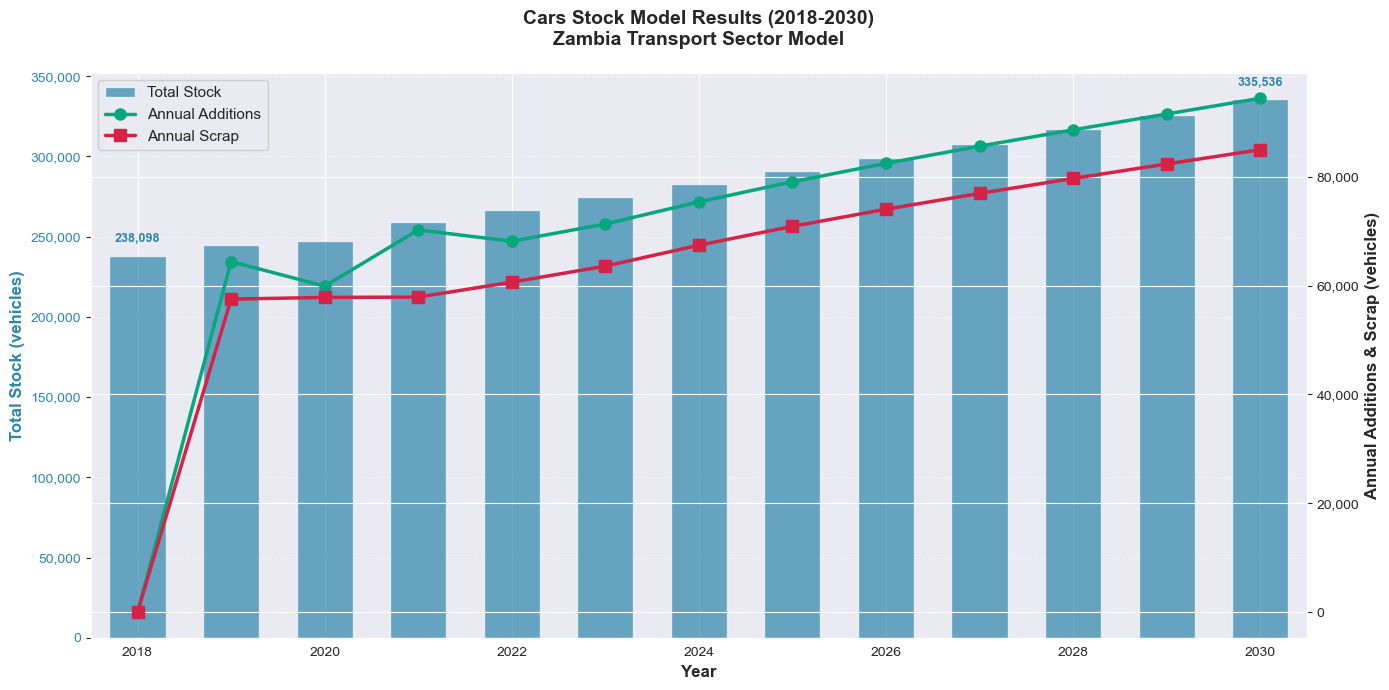


SUMMARY STATISTICS: Cars
Base Year (2018) Stock:        238,098 vehicles
Final Year (2030) Stock:        335,536 vehicles
Absolute Growth:                       97,437 vehicles
Percentage Growth:                       40.9%

Total Additions (2019-2030):    931,281 vehicles
Total Scrap (2018-2029):      833,844 vehicles
Net Change:                            97,437 vehicles

Average Annual Additions:              77,606 vehicles/year
Average Annual Scrap:                  69,487 vehicles/year
Average Scrappage Rate:                   1.7% of fleet/year


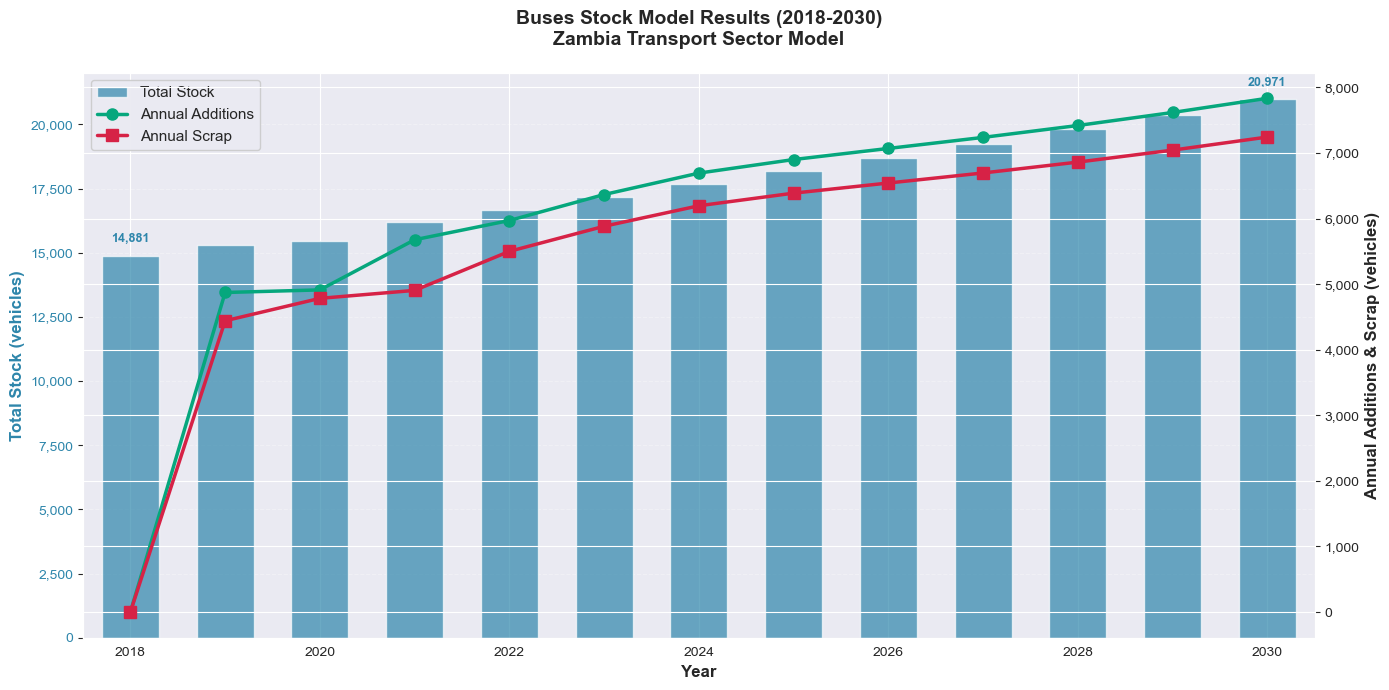


SUMMARY STATISTICS: Buses
Base Year (2018) Stock:         14,881 vehicles
Final Year (2030) Stock:         20,971 vehicles
Absolute Growth:                        6,090 vehicles
Percentage Growth:                       40.9%

Total Additions (2019-2030):     78,569 vehicles
Total Scrap (2018-2029):       72,479 vehicles
Net Change:                             6,090 vehicles

Average Annual Additions:               6,547 vehicles/year
Average Annual Scrap:                   6,039 vehicles/year
Average Scrappage Rate:                   2.4% of fleet/year


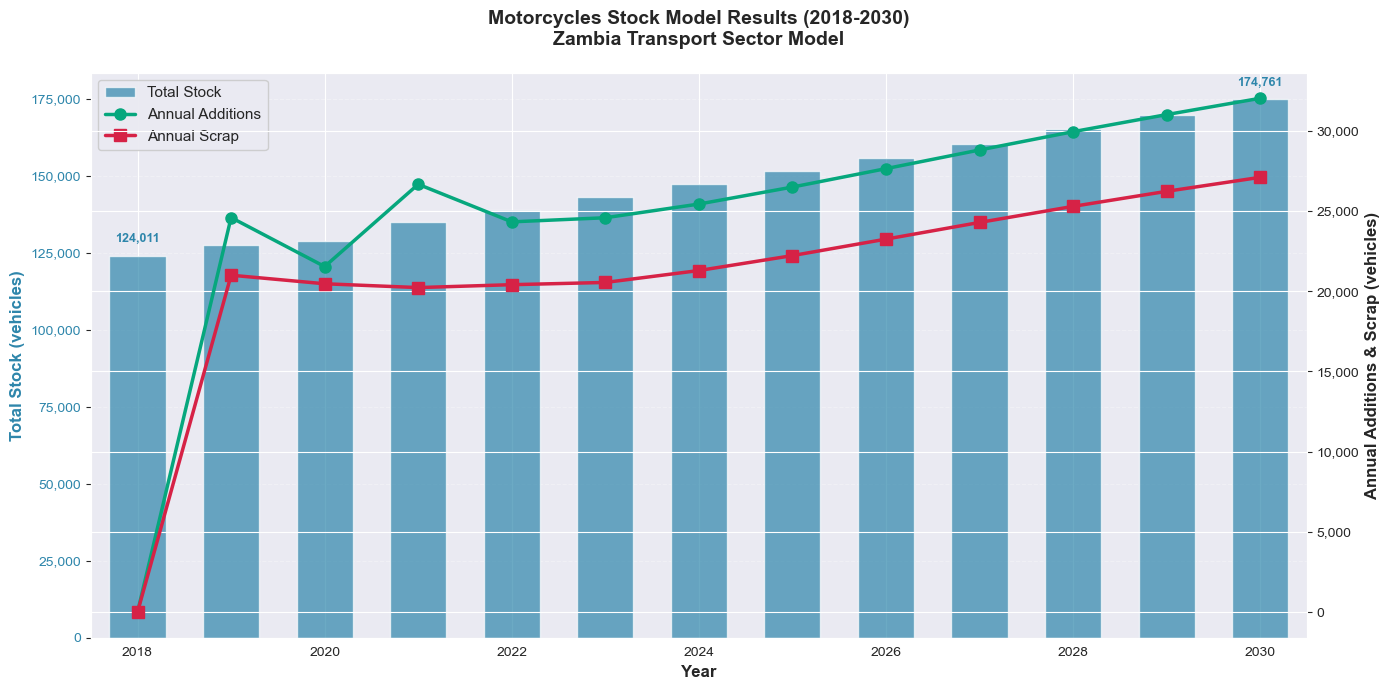


SUMMARY STATISTICS: Motorcycles
Base Year (2018) Stock:        124,011 vehicles
Final Year (2030) Stock:        174,761 vehicles
Absolute Growth:                       50,750 vehicles
Percentage Growth:                       40.9%

Total Additions (2019-2030):    323,037 vehicles
Total Scrap (2018-2029):      272,287 vehicles
Net Change:                            50,750 vehicles

Average Annual Additions:              26,919 vehicles/year
Average Annual Scrap:                  22,690 vehicles/year
Average Scrappage Rate:                   1.1% of fleet/year


In [180]:
def plot_stock_model_results(vehicle_type='CAR', start_year=2018, end_year=2030):
    """
    Plot the annual stock, additions, and scrap for a given vehicle type.

    Parameters:
    - vehicle_type: str, one of 'CAR', 'BUS', 'MOTO'
    - start_year: int, starting year (default 2018)
    - end_year: int, ending year (default 2030)
    """

    # Get the model results
    annual_stock, annual_additions, annual_scrap = calculate_annual_stock_additions_scrap(
        start_year=start_year,
        end_year=end_year
    )

    # Extract totals for each year
    years = list(range(start_year, end_year + 1))
    stock_totals = []
    additions_totals = []
    scrap_totals = []

    for year in years:
        stock_totals.append(sum(annual_stock[year][vehicle_type].values()))

        # Additions start from 2019
        if year > start_year:
            additions_totals.append(sum(annual_additions[year][vehicle_type].values()))
        else:
            additions_totals.append(0)  # No additions in base year

        # Scrap calculated from year-1's stock, so first scrap is 2018
        if year > start_year:
            scrap_totals.append(sum(annual_scrap[year-1][vehicle_type].values()))
        else:
            scrap_totals.append(0)  # No scrap calculated for base year

    # Create the plot
    fig, ax = plt.subplots(figsize=(14, 7))

    # Plot stock as bars
    bars = ax.bar(years, stock_totals, color='#2E86AB', alpha=0.7, label='Total Stock', width=0.6)

    # Plot additions and scrap as lines
    ax2 = ax.twinx()
    line1 = ax2.plot(years, additions_totals, color='#06A77D', marker='o', linewidth=2.5,
                     markersize=8, label='Annual Additions')
    line2 = ax2.plot(years, scrap_totals, color='#D62246', marker='s', linewidth=2.5,
                     markersize=8, label='Annual Scrap')

    # Labels and title
    ax.set_xlabel('Year', fontsize=12, fontweight='bold')
    ax.set_ylabel('Total Stock (vehicles)', fontsize=12, fontweight='bold', color='#2E86AB')
    ax2.set_ylabel('Annual Additions & Scrap (vehicles)', fontsize=12, fontweight='bold')

    vehicle_names = {'CAR': 'Cars', 'BUS': 'Buses', 'MOTO': 'Motorcycles'}
    ax.set_title(f'{vehicle_names[vehicle_type]} Stock Model Results (2018-2030)\n'
                 f'Zambia Transport Sector Model',
                 fontsize=14, fontweight='bold', pad=20)

    # Formatting
    ax.tick_params(axis='y', labelcolor='#2E86AB')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_xlim(start_year - 0.5, end_year + 0.5)

    # Format y-axis with thousand separators
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))

    # Combine legends - FIX HERE
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2,
              loc='upper left', fontsize=11, framealpha=0.95)

    # Add annotations for key years
    for i, year in enumerate([start_year, end_year]):
        idx = years.index(year)
        ax.annotate(f'{int(stock_totals[idx]):,}',
                   xy=(year, stock_totals[idx]),
                   xytext=(0, 10),
                   textcoords='offset points',
                   ha='center',
                   fontsize=9,
                   fontweight='bold',
                   color='#2E86AB')

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\n" + "=" * 70)
    print(f"SUMMARY STATISTICS: {vehicle_names[vehicle_type]}")
    print("=" * 70)
    print(f"Base Year ({start_year}) Stock:     {int(stock_totals[0]):>10,} vehicles")
    print(f"Final Year ({end_year}) Stock:     {int(stock_totals[-1]):>10,} vehicles")
    print(f"Absolute Growth:                   {int(stock_totals[-1] - stock_totals[0]):>10,} vehicles")
    print(f"Percentage Growth:                 {((stock_totals[-1]/stock_totals[0])-1)*100:>10.1f}%")
    print(f"\nTotal Additions (2019-{end_year}): {int(sum(additions_totals)):>10,} vehicles")
    print(f"Total Scrap (2018-{end_year-1}):   {int(sum(scrap_totals)):>10,} vehicles")
    print(f"Net Change:                        {int(sum(additions_totals) - sum(scrap_totals)):>10,} vehicles")
    print(f"\nAverage Annual Additions:          {int(sum(additions_totals)/(end_year-start_year)):>10,} vehicles/year")
    print(f"Average Annual Scrap:              {int(sum(scrap_totals)/(end_year-start_year)):>10,} vehicles/year")
    print(f"Average Scrappage Rate:            {(sum(scrap_totals)/sum(stock_totals))*100/(end_year-start_year+1):>10.1f}% of fleet/year")
    print("=" * 70)

# Plot all three vehicle types
for vehicle in ['CAR', 'BUS', 'MOTO']:
    plot_stock_model_results(vehicle)

# TECHNOLOGY CHOICE

Next, we will take each annual_additions value and run it through a technology choice model. Stay tuned...

We have the following data tables:
1. technology
2. tech_costs
3. size_split
4. fuel_price

# First: TCO! Applies to buses, trucks, trains, planes and ships.

Step 1: Calculate TCO for all technologies
  ↓ [calculate_simple_tco()]

Step 2a: Get SIZE SPLITS from CSV
  ↓ [size_splits.csv] → "30% mini, 55% urban, 15% coach"

Step 2b: Get TECHNOLOGY shares WITHIN EACH SIZE
  ↓ [calculate_tco_market_shares_by_size()] → "For mini: 60% diesel, 30% CNG, 10% electric"

Step 3: Combine to get final distribution
  ↓ Total mini buses × (60% diesel, 30% CNG, 10% electric)

In [181]:
def load_vehicle_stock_data():
    """
    Load all vehicle stock model data tables as DataFrames.

    Returns:
    - technology_df: Technology specifications
    - fuel_price_df: Fuel prices by fuel type
    - size_split_df: Market size splits by year
    """

    # Load technology data
    technology_df = pd.read_csv('./../data/vehicle_stock/technology.csv')

    # Load fuel price data
    fuel_price_df = pd.read_csv('./../data/vehicle_stock/fuel_price.csv')

    # Load size split data
    size_split_df = pd.read_csv('./../data/vehicle_stock/size_split.csv')

    supply_penalty_df = pd.read_csv('./../data/vehicle_stock/supply_penalty.csv')

    return technology_df, fuel_price_df, size_split_df, supply_penalty_df

In [182]:
def calculate_simple_tco(tech_df, fuel_price_df, year, discount_rate=0.10):
    """
    Calculate simple TCO for all vehicle types.

    Parameters:
    - tech_df: DataFrame with technology data
    - fuel_price_df: DataFrame with fuel prices
    - year: Year for which to calculate TCO
    - discount_rate: Annual discount rate (default 10% for SSA)

    Returns:
    - DataFrame with TCO calculations for each technology
    """

    # Get kilometrage data from return_input_data function
    _, _, _, kilometrage_by_mode = return_input_data()
    km_data = kilometrage_by_mode[year]

    # Merge technology data with fuel prices
    tech_costs = tech_df.copy()
    tech_costs = tech_costs.merge(fuel_price_df, on='FuelID', how='left')

    # Calculate total fuel price per unit
    tech_costs['FuelPriceTotal'] = (tech_costs['BasicCost'] + tech_costs['Duty']) * tech_costs['ValueAddedTax']

    # Map VehTypeID to mode names to get annual km
    veh_type_to_mode = {
        2: 'MOTO',
        3: 'CAR',
        4: 'BUS',
        5: 'TRUCK',
        6: 'TRAIN',  # Passenger rail
        7: 'SHIP',
        8: 'PLANE'
    }

    # Add annual km based on vehicle type
    tech_costs['AnnualKm'] = tech_costs['VehTypeID'].map(
        lambda vt: km_data.get(veh_type_to_mode.get(vt, 'CAR'), 15000)
    )

    # For freight rail, use RAIL_FREIGHT
    freight_rail_mask = (tech_costs['VehTypeID'] == 6) & (tech_costs['TransTypeID'] == 2)
    tech_costs.loc[freight_rail_mask, 'AnnualKm'] = km_data['RAIL_FREIGHT']

    # For air freight, use AIR_FREIGHT
    air_freight_mask = (tech_costs['VehTypeID'] == 8) & (tech_costs['TransTypeID'] == 2)
    tech_costs.loc[air_freight_mask, 'AnnualKm'] = km_data['AIR_FREIGHT']

    # Calculate annual fuel cost
    # spec_energ_consump is in units per 100km
    tech_costs['AnnualFuelCost'] = (
            tech_costs['spec_energ_consump'] / 100 *
            tech_costs['AnnualKm'] *
            tech_costs['FuelPriceTotal']
    )

    # For PHEVs and BEVs, add electric costs
    tech_costs['AnnualElectricCost'] = 0.0
    electric_mask = tech_costs['spec_energ_electric'].notna() & (tech_costs['spec_energ_electric'] > 0)

    if electric_mask.any():
        # Get electricity price (FuelID=12)
        elec_price = fuel_price_df[fuel_price_df['FuelID'] == 12]
        if not elec_price.empty:
            elec_price_total = (elec_price['BasicCost'].values[0] + elec_price['Duty'].values[0]) * \
                               elec_price['ValueAddedTax'].values[0]
            tech_costs.loc[electric_mask, 'AnnualElectricCost'] = (
                    tech_costs.loc[electric_mask, 'spec_energ_electric'] / 100 *
                    tech_costs.loc[electric_mask, 'AnnualKm'] *
                    elec_price_total
            )

    # Total annual running cost (fuel + electric)
    tech_costs['AnnualRunningCost'] = tech_costs['AnnualFuelCost'] + tech_costs['AnnualElectricCost']

    # Calculate Present Value of running costs over vehicle life
    # PV = Annual_Cost * [(1 - (1 + r)^-n) / r]
    tech_costs['PV_RunningCost'] = tech_costs.apply(
        lambda row: row['AnnualRunningCost'] *
                    ((1 - (1 + discount_rate) ** (-row['AveEconLife'])) / discount_rate)
        if row['AveEconLife'] > 0 else 0,
        axis=1
    )

    # Calculate Total Cost of Ownership (TCO)
    tech_costs['TCO'] = tech_costs['PurchasePrice'] + tech_costs['PV_RunningCost']

    # Calculate Equivalent Annual Cost (EAC)
    tech_costs['EAC'] = tech_costs.apply(
        lambda row: row['TCO'] /
                    ((1 - (1 + discount_rate) ** (-row['AveEconLife'])) / discount_rate)
        if row['AveEconLife'] > 0 else row['TCO'],
        axis=1
    )

    return tech_costs

In [183]:
def apply_supply_penalties(tech_costs_df, year, supply_penalty_df):
    """
    Apply supply penalties to technology costs.

    Parameters:
    - tech_costs_df: DataFrame with EAC calculations
    - year: Current year
    - supply_penalty_df: DataFrame with supply penalties

    Returns:
    - tech_costs_df with EffectiveEAC column (EAC + penalties)
    """

    tech_costs_df = tech_costs_df.copy()
    tech_costs_df['SupplyPenalty'] = 0.0
    tech_costs_df['EffectiveEAC'] = tech_costs_df['EAC']

    if supply_penalty_df.empty:
        return tech_costs_df

    # Filter penalties active in this year
    active_penalties = supply_penalty_df[supply_penalty_df['Year'] <= year]

    for _, penalty_row in active_penalties.iterrows():
        # Build filter conditions
        mask = (tech_costs_df['VehTypeID'] == penalty_row['VehTypeID'])

        # Apply to specific fuel type if specified
        if pd.notna(penalty_row['FuelID']):
            mask &= (tech_costs_df['FuelID'] == penalty_row['FuelID'])

        # Apply to specific tech if specified (overrides fuel-level penalty)
        if pd.notna(penalty_row.get('TechID')):
            mask &= (tech_costs_df['TechID'] == penalty_row['TechID'])

        # Apply penalty
        tech_costs_df.loc[mask, 'SupplyPenalty'] = penalty_row['SupplyPenalty']

    # Calculate effective EAC
    tech_costs_df['EffectiveEAC'] = tech_costs_df['EAC'] + tech_costs_df['SupplyPenalty']

    return tech_costs_df

In [184]:
def calculate_appropriate_alpha(tech_costs_df, veh_type_id, target_diversity=0.10, cost_col='EAC'):
    """
    Calculate an appropriate alpha value based on the range of cost values.

    Parameters:
    - tech_costs_df: DataFrame with cost values
    - veh_type_id: Vehicle type ID
    - target_diversity: Acceptable cost premium (e.g., 0.10 = 10% more expensive)
    - cost_col: Which cost column to use ('EAC' or 'EffectiveEAC')

    Returns:
    - Suggested alpha value
    """

    # Get cost values for this vehicle type
    cost_values = tech_costs_df[
        tech_costs_df['VehTypeID'] == veh_type_id
    ][cost_col].dropna()

    if len(cost_values) < 2:
        return -0.001  # Default for single tech

    # Find typical cost and range
    median_cost = cost_values.median()
    min_cost = cost_values.min()
    max_cost = cost_values.max()

    suggested_alpha = -0.85 / (target_diversity * median_cost)

    print(f"VehType {veh_type_id} {cost_col} range: ${min_cost:,.0f} to ${max_cost:,.0f} (median: ${median_cost:,.0f})")
    print(f"  → Suggested alpha: {suggested_alpha:.6f}")

    return suggested_alpha

In [185]:
def calculate_tco_market_shares_by_size(tech_costs_df, veh_type_id, year, alpha=None,
                                       verbose=True, use_effective_eac=True):
    """
    Calculate market shares separately for each size category within a vehicle type.
    Uses log-sum-exp trick for numerical stability.

    Parameters:
    - tech_costs_df: DataFrame with technology costs (must have EffectiveEAC if use_effective_eac=True)
    - veh_type_id: Vehicle type ID (4=BUS, 5=TRUCK, 6=RAIL, 7=SHIP, 8=PLANE)
    - year: Current year
    - alpha: Cost sensitivity parameter (if None, auto-calculate)
    - verbose: Print calculation details
    - use_effective_eac: Use EffectiveEAC (with penalties) instead of EAC

    Returns:
    - Dict of {MassCatID: {TechID: market_share}}
    """

    # Choose which cost metric to use
    cost_col = 'EffectiveEAC' if use_effective_eac else 'EAC'

    # Auto-calculate alpha if not provided
    if alpha is None:
        if verbose:
            print(f"\nAuto-calculating alpha for VehType {veh_type_id}:")
        alpha = calculate_appropriate_alpha(tech_costs_df, veh_type_id, target_diversity=0.10, cost_col=cost_col)

    # Get all size categories for this vehicle type
    size_categories = tech_costs_df[
        tech_costs_df['VehTypeID'] == veh_type_id
    ]['MassCatID'].unique()

    market_shares_by_size = {}

    for size_cat in size_categories:
        # Filter for this vehicle type AND size category
        available_techs = tech_costs_df[
            (tech_costs_df['VehTypeID'] == veh_type_id) &
            (tech_costs_df['MassCatID'] == size_cat) &
            (tech_costs_df['Availability'] <= year) &
            ((tech_costs_df['Final_Year'].isna()) | (tech_costs_df['Final_Year'] >= year))
        ].copy()

        if len(available_techs) == 0:
            continue

        # Calculate utility and market shares using log-sum-exp trick
        available_techs['Utility'] = alpha * available_techs[cost_col]

        # Log-sum-exp trick
        max_utility = available_techs['Utility'].max()
        available_techs['Utility_shifted'] = available_techs['Utility'] - max_utility
        available_techs['exp_utility'] = np.exp(available_techs['Utility_shifted'])

        sum_exp = available_techs['exp_utility'].sum()
        available_techs['MarketShare'] = available_techs['exp_utility'] / sum_exp

        # Store market shares for this size category
        market_shares_by_size[size_cat] = dict(
            zip(available_techs['TechID'], available_techs['MarketShare'])
        )

    return market_shares_by_size


In [186]:
def calculate_all_tco_market_shares(tech_costs_df, year, verbose=True):
    """
    Calculate market shares by size for all TCO-based vehicle types.

    Parameters:
    - tech_costs_df: DataFrame with technology costs
    - year: Current simulation year
    - verbose: Print progress

    Returns:
    - Dict of {VehTypeID: {MassCatID: {TechID: market_share}}}
    """

    tco_vehicle_types = [4, 5, 6, 7, 8]  # BUS, TRUCK, RAIL, SHIP, PLANE
    veh_type_names = {4: 'BUS', 5: 'TRUCK', 6: 'RAIL', 7: 'SHIP', 8: 'PLANE'}

    all_market_shares = {}

    if verbose:
        print("=" * 80)
        print(f"CALCULATING TCO-BASED MARKET SHARES - YEAR {year}")
        print("=" * 80)

    for veh_type in tco_vehicle_types:
        if verbose:
            print(f"\n{veh_type_names[veh_type]}:")
            print("-" * 80)

        all_market_shares[veh_type] = calculate_tco_market_shares_by_size(
            tech_costs_df,
            veh_type,
            year,
            verbose=verbose
        )

    return all_market_shares

In [187]:
def display_market_shares_by_size(market_shares_by_size, tech_costs_df, veh_type_id, year, top_n=10):
    """
    Display market shares by size category in a readable format.

    Parameters:
    - market_shares_by_size: Output from calculate_tco_market_shares_by_size
    - tech_costs_df: DataFrame with technology costs
    - veh_type_id: Vehicle type ID
    - year: Year for display
    - top_n: Number of top technologies to display per size
    """

    veh_type_names = {4: 'BUS', 5: 'TRUCK', 6: 'RAIL', 7: 'SHIP', 8: 'PLANE'}

    # Size category names
    size_names = {
        # Buses
        11: 'Mini Bus',
        12: 'Urban Bus',
        13: 'Coach',
        # Trucks
        21: 'Panel Van',
        22: 'Medium Truck',
        23: 'Heavy Truck',
        # Rail
        31: 'Light Rail',
        32: 'Regional Rail',
        33: 'National Rail',
        34: 'High Speed Rail',
        # Ships
        51: 'River Vessel',
        52: 'Coastal Vessel',
        53: 'Maritime Vessel',
        # Planes
        41: 'General Aviation',
        42: 'Short Haul',
        43: 'Medium Haul',
        44: 'Long Haul',
        45: 'Supersonic'
    }

    print("\n" + "=" * 100)
    print(f"{veh_type_names.get(veh_type_id, veh_type_id)} MARKET SHARES BY SIZE - YEAR {year}")
    print("=" * 100)

    for size_cat in sorted(market_shares_by_size.keys()):
        shares = market_shares_by_size[size_cat]

        if len(shares) == 0:
            continue

        print(f"\n{size_names.get(size_cat, f'Size {size_cat}')}:")
        print("-" * 100)
        print(f"{'TechID':<10} {'FuelID':<10} {'Hybrid':<10} {'EAC':>15} {'Market Share':>15}")
        print("-" * 100)

        # Get details for each technology
        for tech_id, share in sorted(shares.items(), key=lambda x: -x[1])[:top_n]:
            tech_row = tech_costs_df[tech_costs_df['TechID'] == tech_id].iloc[0]
            print(f"{tech_id:<10.0f} {tech_row['FuelID']:<10.0f} {tech_row['HybridFlag']:<10.0f} "
                  f"${tech_row['EAC']:>14,.0f} {share:>14.1%}")

        # Show concentration metrics
        sorted_shares = sorted(shares.values(), reverse=True)
        top3 = sum(sorted_shares[:3])
        top5 = sum(sorted_shares[:5]) if len(sorted_shares) >= 5 else sum(sorted_shares)

        print(f"\nTop 3 technologies: {top3:.1%} | Top 5 technologies: {top5:.1%} | Total: {sum(shares.values()):.1%}")

In [188]:
def validate_market_share_calculation(tech_costs_df, veh_type_id, size_cat, year, alpha, num_examples=5):
    """
    Validate and explain market share calculations step-by-step for a specific size category.

    Parameters:
    - tech_costs_df: DataFrame with technology costs
    - veh_type_id: Vehicle type ID to validate
    - size_cat: Size category (MassCatID) to validate
    - year: Year to validate
    - alpha: Cost sensitivity parameter used
    - num_examples: Number of technologies to show in detail
    """

    # Filter available technologies
    available_techs = tech_costs_df[
        (tech_costs_df['VehTypeID'] == veh_type_id) &
        (tech_costs_df['MassCatID'] == size_cat) &
        (tech_costs_df['Availability'] <= year) &
        ((tech_costs_df['Final_Year'].isna()) | (tech_costs_df['Final_Year'] >= year))
        ].copy()

    # Calculate utilities
    available_techs['Utility'] = alpha * available_techs['EAC']

    # Log-sum-exp trick
    max_utility = available_techs['Utility'].max()
    available_techs['Utility_shifted'] = available_techs['Utility'] - max_utility
    available_techs['exp_utility'] = np.exp(available_techs['Utility_shifted'])
    sum_exp = available_techs['exp_utility'].sum()
    available_techs['MarketShare'] = available_techs['exp_utility'] / sum_exp

    # Sort by market share
    available_techs = available_techs.sort_values('MarketShare', ascending=False)

    veh_type_names = {4: 'BUS', 5: 'TRUCK', 6: 'RAIL', 7: 'SHIP', 8: 'PLANE'}
    size_names = {11: 'Mini', 12: 'Urban', 13: 'Coach', 21: 'Panel', 22: 'Medium', 23: 'Heavy'}

    print("=" * 100)
    print(
        f"VALIDATION: {veh_type_names.get(veh_type_id, veh_type_id)} - {size_names.get(size_cat, size_cat)} (Year {year})")
    print("=" * 100)
    print(f"\nAlpha (cost sensitivity): {alpha:.8f}")
    print(f"Total technologies available: {len(available_techs)}")
    print(f"\nFormula: MarketShare_i = exp(α × EAC_i) / Σ exp(α × EAC_j)")

    # Show top examples in detail
    print(f"\n{'=' * 100}")
    print(f"DETAILED CALCULATION (Top {num_examples} technologies)")
    print(f"{'=' * 100}")
    print(f"{'TechID':<10} {'EAC':>12} {'Utility':>15} {'exp(Utility)':>18} {'Market Share':>15}")
    print("-" * 100)

    for idx, row in available_techs.head(num_examples).iterrows():
        print(f"{row['TechID']:<10.0f} ${row['EAC']:>11,.0f} "
              f"{row['Utility']:>15.4f} {row['exp_utility']:>18.6e} {row['MarketShare']:>14.1%}")

    print("-" * 100)
    print(f"{'Total':<10} {'':<12} {'':<15} {'=':<18} {sum_exp:>18.6e}")
    print(f"{'=' * 100}")

    # Verify sum
    total_share = available_techs['MarketShare'].sum()
    print(f"\n✓ Total market share: {total_share:.6f} (should be 1.0)")

    return available_techs

In [189]:
## TEST!

# Load data
technology_df, fuel_price_df, size_split_df, supply_penalty_df = load_vehicle_stock_data()

# Calculate TCO for 2025
print("Calculating TCO for all technologies in 2025...")
tech_costs_2025 = calculate_simple_tco(technology_df, fuel_price_df, year=2025, discount_rate=0.10)

# Apply supply penalties (even if all zero)
tech_costs_2025 = apply_supply_penalties(tech_costs_2025, year=2025, supply_penalty_df=supply_penalty_df)

# Calculate market shares for all TCO-based vehicles (by size)
all_shares_2025 = calculate_all_tco_market_shares(tech_costs_2025, year=2025)

# Display results for buses
display_market_shares_by_size(all_shares_2025[4], tech_costs_2025, veh_type_id=4, year=2025)

# Display results for trucks
display_market_shares_by_size(all_shares_2025[5], tech_costs_2025, veh_type_id=5, year=2025)

# Validate mini buses
print("\n" * 2)
validate_market_share_calculation(
    tech_costs_2025,
    veh_type_id=4,  # BUS
    size_cat=11,  # Mini
    year=2025,
    alpha=-0.000367,
    num_examples=5
)

Calculating TCO for all technologies in 2025...
CALCULATING TCO-BASED MARKET SHARES - YEAR 2025

BUS:
--------------------------------------------------------------------------------

Auto-calculating alpha for VehType 4:
VehType 4 EffectiveEAC range: $5,386 to $33,572 (median: $23,185)
  → Suggested alpha: -0.000367

TRUCK:
--------------------------------------------------------------------------------

Auto-calculating alpha for VehType 5:
VehType 5 EffectiveEAC range: $4,571 to $57,181 (median: $17,486)
  → Suggested alpha: -0.000486

RAIL:
--------------------------------------------------------------------------------

Auto-calculating alpha for VehType 6:
VehType 6 EffectiveEAC range: $275,108 to $2,234,188 (median: $1,094,036)
  → Suggested alpha: -0.000008

SHIP:
--------------------------------------------------------------------------------

Auto-calculating alpha for VehType 7:
VehType 7 EffectiveEAC range: $6,733,452 to $20,123,770 (median: $15,825,007)
  → Suggested alpha

,TechID,ModeID,VehTypeID,MassCatID,FuelID,EngineID,TransTypeID,Availability,Final_Year,HybridFlag,...,AnnualRunningCost,PV_RunningCost,TCO,EAC,SupplyPenalty,EffectiveEAC,Utility,Utility_shifted,exp_utility,MarketShare
288,654,1,4,11,10,17,1,2025,2030.0,0,...,3435.45696,26130.358778,43950.358778,5778.319664,0.0,5778.319664,-2.120643,0.000000,1.000000,0.325414
287,653,1,4,11,10,16,1,2020,2025.0,0,...,3522.86208,26795.169070,44780.169070,5887.417957,0.0,5887.417957,-2.160682,-0.040039,0.960752,0.312643
319,780,1,4,11,12,8,1,2025,2035.0,0,...,612.86400,4661.492311,74112.679811,9743.873930,0.0,9743.873930,-3.576002,-1.455358,0.233317,0.075925
303,675,1,4,11,1,9,1,2020,NaN,0,...,2912.06520,22149.399439,84901.399439,11162.307647,0.0,11162.307647,-4.096567,-1.975924,0.138633,0.045113
318,750,1,4,11,12,7,1,2015,2025.0,0,...,677.75400,5155.050810,90155.050810,11853.025035,0.0,11853.025035,-4.350060,-2.229417,0.107591,0.035012
341,868,1,4,11,2,17,1,2025,2030.0,1,...,3249.35028,24714.816574,90604.816574,11912.157439,0.0,11912.157439,-4.371762,-2.251118,0.105281,0.034260
340,867,1,4,11,2,16,1,2020,2025.0,1,...,3332.61612,25348.143173,91238.143173,11995.423279,0.0,11995.423279,-4.402320,-2.281677,0.102113,0.033229
333,860,1,4,11,7,17,1,2025,2030.0,0,...,3436.71984,26139.964344,92125.964344,12112.148482,0.0,12112.148482,-4.445158,-2.324515,0.097831,0.031836
332,859,1,4,11,7,16,1,2020,2025.0,0,...,3523.03344,26796.472448,93446.472448,12285.760670,0.0,12285.760670,-4.508874,-2.388231,0.091792,0.029870
309,697,1,4,11,2,17,1,2025,2030.0,0,...,5366.68164,40819.407239,103571.407239,13616.924087,0.0,13616.924087,-4.997411,-2.876768,0.056316,0.018326


For Year Y (e.g., 2025):
  For each vehicle type (BUS, TRUCK, etc.):
    For each age A in additions (0 to 32):

      Vintage Year = Y - A

      1. Calculate TCO/EAC for technologies available in Vintage Year
      2. Calculate market shares by size for Vintage Year
      3. Get size splits for Vintage Year
      4. Distribute additions[A] across sizes and technologies

      Result: age A vehicles distributed by size × technology

In [190]:
def calculate_vintage_technology_distribution(annual_additions, tech_df, fuel_price_df,
                                             size_split_df, year, veh_type_id,
                                             supply_penalty_df=None, discount_rate=0.10):
    """
    Apply age-specific technology vintages to vehicle additions.
    NOW WITH SUPPLY PENALTIES!

    Parameters:
    - annual_additions: Dict of {age: num_vehicles}
    - tech_df: Technology DataFrame
    - fuel_price_df: Fuel prices DataFrame
    - size_split_df: Size splits DataFrame
    - year: Current simulation year
    - veh_type_id: Vehicle type ID
    - supply_penalty_df: Supply penalty DataFrame (optional)
    - discount_rate: Discount rate for TCO calculation

    Returns:
    - DataFrame with columns: Age, VintageYear, MassCatID, TechID, NumVehicles
    """

    veh_type_names = {4: 'BUS', 5: 'TRUCK', 6: 'RAIL', 7: 'SHIP', 8: 'PLANE', 3: 'CAR', 2: 'MOTO'}
    veh_name = veh_type_names.get(veh_type_id, str(veh_type_id))

    size_split_cols = {
        4: {11: 'BMini', 12: 'BUrban', 13: 'BCoach'},
        5: {21: 'TPanel', 22: 'TMedium', 23: 'THeavy'},
        6: {31: 'RLight', 32: 'RRegional', 33: 'RNational', 34: 'RHighSpeed'},
        7: {51: 'SRiver', 52: 'SCoastal', 53: 'SMaritime'},
        8: {41: 'PGeneral', 42: 'PShort', 43: 'PMedium', 44: 'PLong', 45: 'PSupersonic'}
    }

    results = []

    print(f"\n{'='*100}")
    print(f"DISTRIBUTING {veh_name} ADDITIONS BY AGE-VINTAGE TECHNOLOGY - YEAR {year}")
    print(f"{'='*100}")

    # Calculate TCO for current year
    print(f"\nCalculating TCO for current year {year}...")
    tech_costs_current = calculate_simple_tco(
        tech_df, fuel_price_df, year=year, discount_rate=discount_rate
    )

    # Apply supply penalties
    if supply_penalty_df is not None and not supply_penalty_df.empty:
        print(f"Applying supply penalties for year {year}...")
        tech_costs_current = apply_supply_penalties(tech_costs_current, year, supply_penalty_df)

        # Show active penalties
        active = tech_costs_current[tech_costs_current['SupplyPenalty'] > 0]
        if len(active) > 0:
            print(f"  → {len(active)} technologies have supply penalties")
            print(f"  → Penalty range: ${active['SupplyPenalty'].min():,.0f} to ${active['SupplyPenalty'].max():,.0f}")

    for age, num_vehicles in annual_additions.items():
        if num_vehicles == 0:
            continue

        vintage_year = year - age

        print(f"\nAge {age} ({num_vehicles:.0f} vehicles) - Vintage Year {vintage_year}:")

        # Filter technologies available in vintage year
        available_techs = tech_costs_current[
            (tech_costs_current['VehTypeID'] == veh_type_id) &
            (tech_costs_current['Availability'] <= vintage_year) &
            ((tech_costs_current['Final_Year'].isna()) | (tech_costs_current['Final_Year'] >= vintage_year))
        ].copy()

        if len(available_techs) == 0:
            print(f"  ⚠️ Warning: No technologies available for vintage year {vintage_year}")
            continue

        # Calculate market shares by size (using EffectiveEAC with penalties)
        market_shares_by_size = {}
        size_categories = available_techs['MassCatID'].unique()

        alpha = calculate_appropriate_alpha(available_techs, veh_type_id, target_diversity=0.10, cost_col='EffectiveEAC')

        for size_cat in size_categories:
            size_techs = available_techs[available_techs['MassCatID'] == size_cat].copy()

            if len(size_techs) == 0:
                continue

            # Use EffectiveEAC (includes penalties)
            size_techs['Utility'] = alpha * size_techs['EffectiveEAC']
            max_utility = size_techs['Utility'].max()
            size_techs['Utility_shifted'] = size_techs['Utility'] - max_utility
            size_techs['exp_utility'] = np.exp(size_techs['Utility_shifted'])
            sum_exp = size_techs['exp_utility'].sum()
            size_techs['MarketShare'] = size_techs['exp_utility'] / sum_exp

            market_shares_by_size[size_cat] = dict(
                zip(size_techs['TechID'], size_techs['MarketShare'])
            )

        # Get size splits for vintage year
        vintage_year_clamped = max(vintage_year, size_split_df['Year'].min())
        vintage_year_clamped = min(vintage_year_clamped, size_split_df['Year'].max())

        size_splits_row = size_split_df[size_split_df['Year'] == vintage_year_clamped]

        if size_splits_row.empty:
            continue

        size_splits_row = size_splits_row.iloc[0]
        size_col_map = size_split_cols.get(veh_type_id, {})

        # Distribute vehicles
        for mass_cat_id, col_name in size_col_map.items():
            if col_name not in size_splits_row:
                continue

            size_proportion = size_splits_row[col_name]
            num_vehicles_size = num_vehicles * size_proportion

            if num_vehicles_size < 0.01:
                continue

            tech_shares = market_shares_by_size.get(mass_cat_id, {})

            if not tech_shares:
                continue

            for tech_id, tech_share in tech_shares.items():
                num_vehicles_tech = num_vehicles_size * tech_share

                if num_vehicles_tech >= 0.01:
                    results.append({
                        'Age': age,
                        'VintageYear': vintage_year,
                        'MassCatID': mass_cat_id,
                        'TechID': tech_id,
                        'NumVehicles': num_vehicles_tech
                    })

        age_total = sum([r['NumVehicles'] for r in results if r['Age'] == age])
        print(f"  → Distributed {age_total:.1f} vehicles")

    distribution_df = pd.DataFrame(results)

    total_distributed = distribution_df['NumVehicles'].sum()
    total_input = sum(annual_additions.values())

    print(f"\n{'='*100}")
    print(f"SUMMARY:")
    print(f"  Input total: {total_input:.1f} vehicles")
    print(f"  Distributed: {total_distributed:.1f} vehicles")
    print(f"  Difference: {abs(total_distributed - total_input):.1f}")
    print(f"{'='*100}")

    return distribution_df

In [191]:
def summarize_technology_distribution(distribution_df, tech_df):
    """
    Summarize the technology distribution results.

    Parameters:
    - distribution_df: Output from calculate_vintage_technology_distribution
    - tech_df: Technology DataFrame (for fuel names, etc.)

    Returns:
    - Summary DataFrame
    """

    # Merge with technology info (don't duplicate MassCatID)
    summary = distribution_df.merge(
        tech_df[['TechID', 'FuelID', 'HybridFlag']],
        on='TechID',
        how='left'
    )

    # Aggregate by fuel type
    fuel_summary = summary.groupby('FuelID')['NumVehicles'].sum().sort_values(ascending=False)

    print("\n" + "="*80)
    print("FUEL TYPE DISTRIBUTION")
    print("="*80)
    for fuel_id, count in fuel_summary.items():
        pct = count / summary['NumVehicles'].sum() * 100
        print(f"FuelID {fuel_id:>2.0f}: {count:>10,.1f} vehicles ({pct:>5.1f}%)")

    # Aggregate by size (use MassCatID from distribution_df)
    size_summary = distribution_df.groupby('MassCatID')['NumVehicles'].sum().sort_values(ascending=False)

    print("\n" + "="*80)
    print("SIZE DISTRIBUTION")
    print("="*80)
    size_names = {
        11: 'Mini Bus', 12: 'Urban Bus', 13: 'Coach',
        21: 'Panel Van', 22: 'Medium Truck', 23: 'Heavy Truck',
        31: 'Light Rail', 32: 'Regional Rail', 33: 'National Rail', 34: 'High Speed Rail',
        51: 'River Vessel', 52: 'Coastal Vessel', 53: 'Maritime Vessel',
        41: 'General Aviation', 42: 'Short Haul', 43: 'Medium Haul', 44: 'Long Haul', 45: 'Supersonic'
    }
    for size_id, count in size_summary.items():
        pct = count / distribution_df['NumVehicles'].sum() * 100
        size_name = size_names.get(size_id, f'Size {size_id}')
        print(f"{size_name:<20}: {count:>10,.1f} vehicles ({pct:>5.1f}%)")

    # Aggregate by vintage year
    vintage_summary = distribution_df.groupby('VintageYear')['NumVehicles'].sum().sort_values(ascending=False)

    print("\n" + "="*80)
    print("VINTAGE YEAR DISTRIBUTION (Top 10)")
    print("="*80)
    for vintage, count in vintage_summary.head(10).items():
        pct = count / distribution_df['NumVehicles'].sum() * 100
        print(f"Year {vintage}: {count:>10,.1f} vehicles ({pct:>5.1f}%)")

    # Top 10 technologies
    tech_summary = summary.groupby('TechID')['NumVehicles'].sum().sort_values(ascending=False)

    print("\n" + "="*80)
    print("TOP 10 TECHNOLOGIES")
    print("="*80)
    for tech_id, count in tech_summary.head(10).items():
        tech_row = tech_df[tech_df['TechID'] == tech_id].iloc[0]
        pct = count / summary['NumVehicles'].sum() * 100
        print(f"TechID {tech_id:>4.0f} (Fuel {tech_row['FuelID']:>2.0f}, Hybrid {tech_row['HybridFlag']:.0f}): "
              f"{count:>10,.1f} vehicles ({pct:>5.1f}%)")

    return summary

In [193]:
# ========== EXAMPLE USAGE ==========

# Your annual_additions for 2025 (example - use your actual data)
bus_additions_2025 = {
    0: 346.45, 1: 779.50, 2: 57.74, 3: 86.61, 4: 0.0, 5: 0.0,
    6: 115.48, 7: 57.74, 8: 86.61, 9: 57.74, 10: 28.87,
    11: 173.22, 12: 28.87, 13: 115.48, 14: 86.61, 15: 173.22,
    16: 433.06, 17: 259.83, 18: 288.71, 19: 259.83, 20: 490.80,
    21: 317.58, 22: 606.28, 23: 317.58, 24: 375.32, 25: 173.22,
    26: 173.22, 27: 202.09, 28: 115.48, 29: 288.71, 30: 259.83,
    31: 57.74, 32: 86.61
}

# Calculate age-vintage technology distribution for buses in 2025
bus_distribution_2025 = calculate_vintage_technology_distribution(
    annual_additions=bus_additions_2025,
    tech_df=technology_df,
    fuel_price_df=fuel_price_df,
    size_split_df=size_split_df,
    year=2025,
    veh_type_id=4,  # BUS
    supply_penalty_df=supply_penalty_df,
    discount_rate=0.10
)

# Summarize results
bus_summary_2025 = summarize_technology_distribution(bus_distribution_2025, technology_df)

# View the detailed distribution
print("\n" + "="*80)
print("DETAILED DISTRIBUTION (First 20 rows)")
print("="*80)
print(bus_distribution_2025.head(20).to_string(index=False))


DISTRIBUTING BUS ADDITIONS BY AGE-VINTAGE TECHNOLOGY - YEAR 2025

Calculating TCO for current year 2025...
Applying supply penalties for year 2025...

Age 0 (346 vehicles) - Vintage Year 2025:
VehType 4 EffectiveEAC range: $5,778 to $33,572 (median: $22,865)
  → Suggested alpha: -0.000372
  → Distributed 346.5 vehicles

Age 1 (780 vehicles) - Vintage Year 2024:
VehType 4 EffectiveEAC range: $5,887 to $33,572 (median: $23,022)
  → Suggested alpha: -0.000369
  → Distributed 779.5 vehicles

Age 2 (58 vehicles) - Vintage Year 2023:
VehType 4 EffectiveEAC range: $5,887 to $33,572 (median: $23,022)
  → Suggested alpha: -0.000369
  → Distributed 57.7 vehicles

Age 3 (87 vehicles) - Vintage Year 2022:
VehType 4 EffectiveEAC range: $5,887 to $33,572 (median: $23,022)
  → Suggested alpha: -0.000369
  → Distributed 86.6 vehicles

Age 6 (115 vehicles) - Vintage Year 2019:
VehType 4 EffectiveEAC range: $5,998 to $33,275 (median: $23,445)
  → Suggested alpha: -0.000363
  → Distributed 115.5 vehicle

# Second - Discrete Choice Module for cars and motorcycles!